In [1]:
import torch as t
import matplotlib.pyplot as plt

In [2]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	10,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  30,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.,
"ascend_start":	20.0,
"level":	0.5,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [6]:
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import json

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [151]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [10]:
exp_path = os.path.join(dir_path,'OptimizationIdeas')
params_dict.update({"exp_path":exp_path})

In [163]:
alphas[560:570]

tensor([0.5118, 0.5111, 0.5106, 0.5000, 0.5103, 0.5105, 0.5109, 0.5116, 0.5126,
        0.5138])

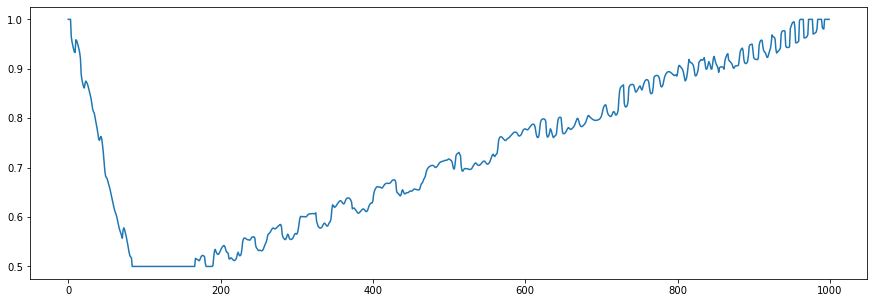

In [185]:
# alphas = t.linspace(0,30,1000)
plt.figure(figsize=(15,5))
# plt.plot(alphas,(t.sin(2*t.pi*2*alphas)*0.1*t.rand(1000) + alphas*(alphas-30)/200+2)*0.3+0.35)
# alphas = t.load("C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Experiments\\Flensmon2D_6\\SymAlpha_XGate_alphas.pt")
# alphas = t.load("C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Experiments\\Flensmon2D_7\\1010_AlphaRun.pt")
alphas = t.load("C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Experiments\\Flensmon2D_7\\1110_AlphaRun.pt")
# alphas[563] = 0.5103
plt.plot(alphas)

In [117]:
class QTrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        self.alphas = alphas
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
QT2 = QTrotter(params_dict)

I added a factor half to the cosines


In [186]:
class ETrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.ETrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        self.alphas = alphas
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

ET3 = ETrotter(params_dict)

I added a factor half to the cosines
No UE0s found, simulating and saving


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


Done


In [187]:
class SavedBasis(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.SavedBasis, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        self.alphas = alphas
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
SB3 = SavedBasis(params_dict)

I added a factor half to the cosines


In [188]:
U0s, E0s = ET3.load_UE0s()

In [122]:
Hs = QT2.get_H(QT2.alphas)
occQT2 = t.zeros(U0s.shape[2],U0s.shape[0],2)
from tqdm import tqdm
bitesize = 100
bites = t.arange(0,QT2.NTrot+bitesize,bitesize)
QTevo = QT2.eigvecs[:,[0,1]]
for i in tqdm(range(bites.shape[0]-1)):
    H = Hs[bites[i]:bites[i+1]]
    exp_mat = t.matrix_exp(-1j*H*QT2.dt)
    for j in range(exp_mat.shape[0]):
        index = i*bitesize + j
        QTevo = exp_mat[j]@QTevo
        occQT2[:,index+1] = (U0s[index].adjoint()@QTevo).abs().square()

100%|██████████| 10/10 [03:51<00:00, 23.14s/it]


In [123]:
# occQT[0,0,0] = 1
# occQT[1,0,1] = 1

In [189]:
ET3()
occET30 = ET3.get_occupancy([_ for _ in range(19)],[0,1]).detach()
# occET2 = ET.get_occupancy([_ for _ in range(19)],[0,1]).detach()
# occET3 = ET.get_occupancy([_ for _ in range(19)],[0,1]).detach()

In [52]:
SB.get_H(SB.alphas).shape

torch.Size([1000, 30, 30])

In [54]:
SB.init_wavefuncs.shape

torch.Size([30, 441])

In [190]:
Hs = SB3.get_H(SB3.alphas)
occSB3 = t.zeros(U0s.shape[2],U0s.shape[0],2)
from tqdm import tqdm
bitesize = 100
bites = t.arange(0,SB3.NTrot+bitesize,bitesize)
SBevo = SB3.init_wavefuncs[:,[0,1]]
for i in tqdm(range(bites.shape[0]-1)):
    H = Hs[bites[i]:bites[i+1]]
    exp_mat = t.matrix_exp(-1j*H*SB3.dt)
    for j in range(exp_mat.shape[0]):
        index = i*bitesize + j
        SBevo = exp_mat[j]@SBevo
        occSB3[:,index+1] = (U0s[index].adjoint()@SB3.basis@SBevo).abs().square()

100%|██████████| 10/10 [00:00<00:00, 39.72it/s]


In [191]:
occSB3[0,0,0] = 1
occSB3[1,0,1] = 1

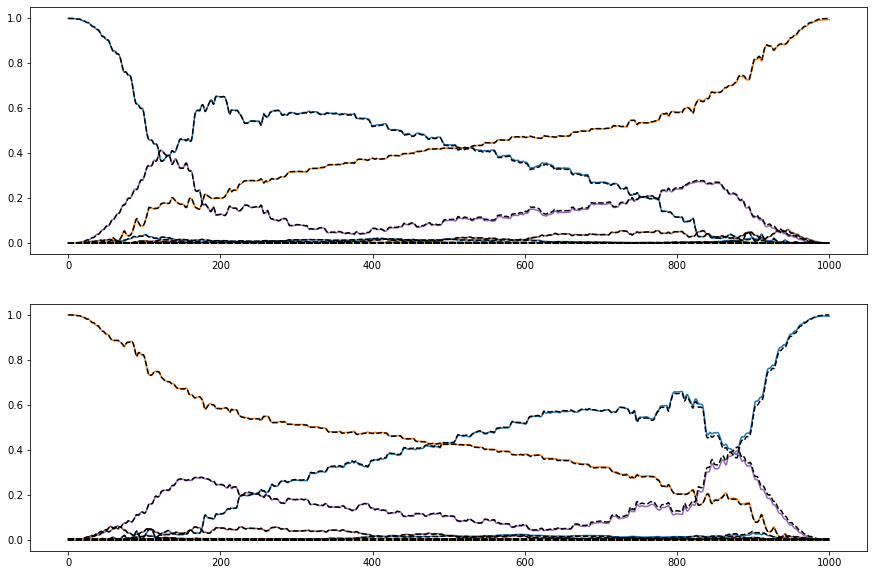

In [115]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2)
# ax[0].plot(occET[:-1,:,0].T);
# ax[1].plot(occET[:-1,:,1].T);

ax[0].plot(occQT[:-1,:,0].T,linestyle='-');
ax[1].plot(occQT[:-1,:,1].T,linestyle='-');

ax[0].plot(occSB[:-1,:,0].T,linestyle='--',c='k');
ax[1].plot(occSB[:-1,:,1].T,linestyle='--',c='k');

# ax[0].plot(occET2[:-1,:,0].T,linestyle='--',c='k');
# ax[1].plot(occET2[:-1,:,1].T,linestyle='--',c='k');

# ax[0].plot(occET3[:-1,:,0].T,linestyle='--');
# ax[1].plot(occET3[:-1,:,1].T,linestyle='--');

In [194]:
occET30[:2,-1], occSB3[:2,-1]

(tensor([[6.6363e-04, 9.9473e-01],
         [9.9570e-01, 7.5313e-04]]),
 tensor([[2.4988e-06, 9.9998e-01],
         [9.9986e-01, 2.8000e-06]]))

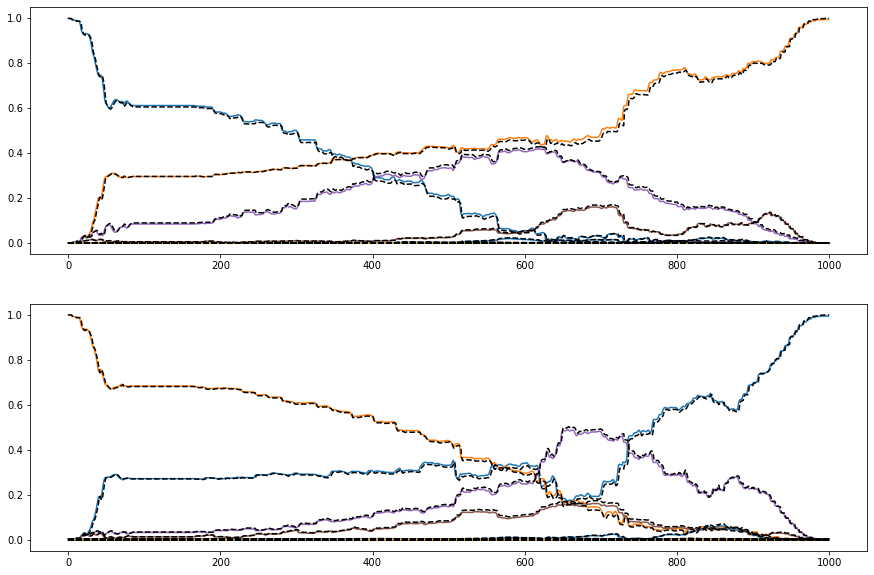

In [192]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2)
ax[0].plot(occET30[:-1,:,0].T);
ax[1].plot(occET30[:-1,:,1].T);

# ax[0].plot(occQT2[:-1,:,0].T,linestyle='-');
# ax[1].plot(occQT2[:-1,:,1].T,linestyle='-');

ax[0].plot(occSB3[:-1,:,0].T,linestyle='--',c='k');
ax[1].plot(occSB3[:-1,:,1].T,linestyle='--',c='k');

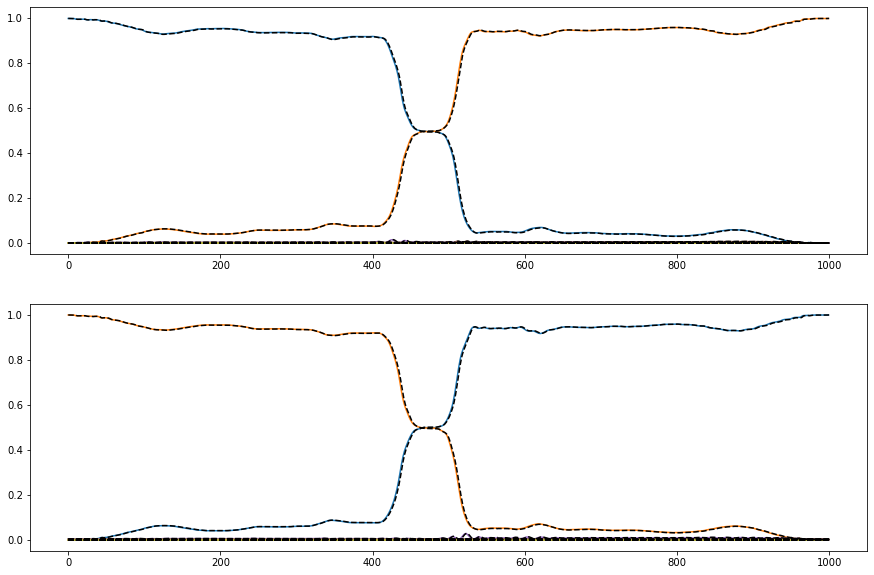

In [176]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2)
ax[0].plot(occET20[:-1,:,0].T);
ax[1].plot(occET20[:-1,:,1].T);

# ax[0].plot(occQT2[:-1,:,0].T,linestyle='-');
# ax[1].plot(occQT2[:-1,:,1].T,linestyle='-');

ax[0].plot(occSB2[:-1,:,0].T,linestyle='--',c='k');
ax[1].plot(occSB2[:-1,:,1].T,linestyle='--',c='k');

# ax[0].plot(occET2[:-1,:,0].T,linestyle='--',c='k');
# ax[1].plot(occET2[:-1,:,1].T,linestyle='--',c='k');

# ax[0].plot(occET3[:-1,:,0].T,linestyle='--');
# ax[1].plot(occET3[:-1,:,1].T,linestyle='--');

In [63]:
sigx = t.tensor([[0,1],[1,0]]).cfloat()
Es = t.linspace(-1,1,101)
Hs = sigx*Es.view(-1,1,1)

def clean_basis(U0s,E0s):
    dim = 2
    threshold = 0.70710678118 #sqrt(0.5)
    for i in range(U0s.shape[0]-1):
        tmp = U0s[i+1].adjoint()@U0s[i]
        perm = (tmp.abs()>=threshold).cfloat()
        assert perm.real.sum() == dim, f"Permutation matrix not Unitary, got {perm.real.sum()}, for step {i}. \n Try using a different subNHilbert."
        U0s[i+1] = U0s[i+1]@perm
        E0s[i+1] = E0s[i+1]@perm

        tmp = U0s[i+1].adjoint()@U0s[i]
        angle = tmp.diagonal().angle()
        U0s[i+1] = U0s[i+1]*t.exp(+1j*angle)
    return U0s, E0s
E0s, U0s = t.linalg.eigh(Hs)
times = t.linspace(0,10,101)
dt = (times[1:] - times[:-1]).mean()

In [64]:
def diff(tensor,dt=dt):
    tmp = t.concat([tensor,tensor[[-1]]],dim=0)
    return (tmp[1:] - tmp[:-1])/dt

In [75]:
Fs = -1/(E0s.unsqueeze(2) - E0s.unsqueeze(1))
Fs[:,[0,1],[0,1]] = 0
U0dot = Fs*(U0s.adjoint()@sigx@U0s)*diff(Es).view(-1,1,1)

In [36]:
sigx = t.tensor([[0,1],[1,0]]).cfloat()
sigy = t.tensor([[0,-1j],[1j,0]]).cfloat()
sigz = t.tensor([[1,0],[0,-1]]).cfloat()
sigs = t.concat([sigx.unsqueeze(0),sigy.unsqueeze(0),sigz.unsqueeze(0)],dim=0)

B0 = t.linspace(-1,1,100)
phi, theta = t.tensor(0.0*t.pi), t.tensor(0.5*t.pi)
B = B0.view(-1,1)*t.tensor([t.cos(phi)*t.sin(theta),t.sin(phi)*t.sin(theta),t.cos(theta)]).view(1,-1)
# H = B*sigs.view(1,3,2,2)
# sigs.shape,B.shape
# t.linalg.eigh(H)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x2 and 100x3)

In [78]:
phi_ext = t.tensor(0.997*t.pi)#3.132167875629024
EJ = 2*t.pi*10#62.83185307179586
EC = EJ/100#0.6283185307179586

In [79]:
def prepare_mats(q_max):
    NH = q_max*2 + 1
    q = t.arange(-q_max,q_max+1,1)
    q_mat = t.diag(q).cfloat()
    cos_mat = 0.5*(t.diag(t.ones(NH-1),-1) + t.diag(t.ones(NH-1),1)).cfloat()
    cos2_mat = 0.5*(t.diag(t.ones(NH-2).cfloat(),-2)*t.exp(-1j*phi_ext) \
                            + t.diag(t.ones(NH-2),2)*t.exp(1j*phi_ext))
    Id = t.eye(NH).cfloat()
    return Id, q_mat, cos_mat, cos2_mat

def prepare_mats_2d(q_max):
    Id, q_mat, cos_mat, cos2_mat = prepare_mats(q_max)

    q_mat = t.kron(q_mat,Id) + t.kron(Id,q_mat)

    cos_mat = t.kron(cos_mat,Id) + t.kron(Id,cos_mat)

    NH = q_max*2 + 1
    upper = t.diag(t.ones(NH-1).cfloat(),1)
    lower = t.diag(t.ones(NH-1).cfloat(),-1)
    cos2_mat = 0.5*(t.exp(1j*phi_ext)*t.kron(lower,upper) + t.exp(-1j*phi_ext)*t.kron(upper,lower))
    Id = t.eye(NH**2).cfloat()
    return Id, q_mat, cos_mat, cos2_mat


def get_H(q_max,alphas=t.tensor([1.]),controls=t.tensor([0.])):
    Id, q_mat, cos_mat, cos2_mat = prepare_mats(q_max)
    KinE = 4*EC*q_mat**2
    V1 = -2*EJ*cos_mat
    V2 = EJ*cos2_mat
    NTrot = alphas.shape[0]
    H = KinE.repeat(NTrot,1,1) + V1.repeat(NTrot,1,1) + alphas.view(-1,1,1)*V2 + controls.view(-1,1,1)*q_mat
    return H.squeeze()

def alpha_run(NTrot,T=30):
    times = t.linspace(0,T,NTrot)
    alphas = t.sin(times)*t.exp(-(times-T/2)**2/10) + t.exp(-times/3) + t.exp(-(T - times)/3)
    alphas = alphas + 0.6313482522964478
    alphas = alphas/1.6313936710357666/2
    alphas = alphas + 0.5
    return alphas

def Trotter(q_max,NTrot,T=30):
    dt = T/(NTrot-1)
    alphas = alpha_run(NTrot,T)
    Hs = get_H(q_max,alphas)
    exp_mat = t.matrix_exp(-1j*Hs*dt)
    U = t.linalg.multi_dot(list(mat for mat in exp_mat.flip(0)))
    return U

In [81]:
H75 = get_H(10,t.tensor([0.75]))
H75

torch.Size([21, 21])

In [101]:
q_max = 10
N_max = 1000
T = 30

def CA_closure(q_max=q_max,N_max=N_max,T=T):
    U_max = Trotter(q_max,N_max,T)
    def calc_acc(U):
        return 0.5*(t.mean(t.square(U.real - U_max.real)) + t.mean(t.square(U.imag - U_max.imag)))
    return calc_acc

calc_acc = CA_closure()

accs = []
Ns = t.linspace(N_max//10,N_max,10).int()

for N in Ns[:-1]:
    accs.append(calc_acc(Trotter(q_max,N,T)))
accs.append(0)
    

In [103]:
def f(N):
    return calc_acc(Trotter(q_max,N,T))



In [1]:
from multiprocessing import Pool

def f(x):
    return x*x

def driver_func():
    PROCESSES = 1
    with Pool(PROCESSES) as pool:
        print(pool.map(f,[0,1,2,3,4]))
if __name__ == '__main__':
    # driver_func()
    print("lol")

lol


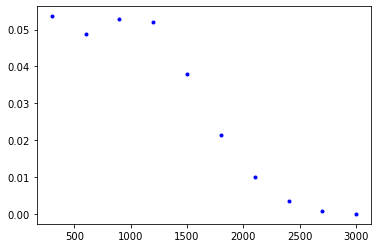

In [82]:
fig, ax = plt.subplots()

ax.plot(Ns,accs,'b.')
# ax.set_yscale('log')

In [1]:
import os
os.cpu_count()

8

In [100]:
Trotter(q_max,2000,30)

tensor([[ 6.9801e-02+6.1739e-01j,  3.1330e-01-4.3505e-01j,
         -1.7535e-01-1.9763e-01j, -1.7889e-01+3.0352e-01j,
          1.1541e-01+2.2717e-02j,  1.1966e-01-1.2224e-01j,
         -6.8240e-02+6.4391e-02j, -3.3042e-02-6.6064e-02j,
          2.6072e-03-1.0636e-06j,  2.9437e-02+4.0778e-02j,
         -9.7087e-03+1.3480e-02j, -4.4716e-02+2.3025e-02j,
          6.2277e-02-5.0943e-02j,  4.8912e-02-3.1663e-02j,
         -1.3152e-01-4.9101e-02j,  4.7566e-02+1.4547e-01j,
         -7.6837e-03+1.2093e-02j,  2.8414e-02-4.4854e-02j,
          9.5761e-03-8.9691e-02j,  9.0308e-03-6.7898e-02j,
          3.5038e-03-3.7684e-02j],
        [ 3.1473e-01-4.3846e-01j,  1.4893e-01+3.9924e-01j,
         -2.1093e-01-3.1466e-01j, -1.0874e-01+1.8248e-01j,
          8.5545e-02+1.5284e-01j,  1.9432e-01-1.5711e-01j,
         -7.1073e-02+5.3749e-02j, -6.8492e-02-1.2370e-01j,
         -9.6423e-03+6.7733e-03j,  4.9499e-02+8.1577e-02j,
         -1.7059e-02+4.3979e-02j, -6.3912e-02+3.7997e-02j,
          1.0895e-01-

In [97]:
t.linspace(0,1,(100 + (100-1)*64))[::16+1]

tensor([0.0000, 0.0026, 0.0053, 0.0079, 0.0106, 0.0132, 0.0159, 0.0185, 0.0211,
        0.0238, 0.0264, 0.0291, 0.0317, 0.0343, 0.0370, 0.0396, 0.0423, 0.0449,
        0.0476, 0.0502, 0.0528, 0.0555, 0.0581, 0.0608, 0.0634, 0.0660, 0.0687,
        0.0713, 0.0740, 0.0766, 0.0793, 0.0819, 0.0845, 0.0872, 0.0898, 0.0925,
        0.0951, 0.0977, 0.1004, 0.1030, 0.1057, 0.1083, 0.1110, 0.1136, 0.1162,
        0.1189, 0.1215, 0.1242, 0.1268, 0.1294, 0.1321, 0.1347, 0.1374, 0.1400,
        0.1427, 0.1453, 0.1479, 0.1506, 0.1532, 0.1559, 0.1585, 0.1611, 0.1638,
        0.1664, 0.1691, 0.1717, 0.1744, 0.1770, 0.1796, 0.1823, 0.1849, 0.1876,
        0.1902, 0.1929, 0.1955, 0.1981, 0.2008, 0.2034, 0.2061, 0.2087, 0.2113,
        0.2140, 0.2166, 0.2193, 0.2219, 0.2246, 0.2272, 0.2298, 0.2325, 0.2351,
        0.2378, 0.2404, 0.2430, 0.2457, 0.2483, 0.2510, 0.2536, 0.2563, 0.2589,
        0.2615, 0.2642, 0.2668, 0.2695, 0.2721, 0.2747, 0.2774, 0.2800, 0.2827,
        0.2853, 0.2880, 0.2906, 0.2932, 

In [77]:
get_H(10,t.tensor([0.75]))

NameError: name 'get_H' is not defined